In [1]:
import math

In [2]:
a = math.pi
for i in range(31):
    a = math.pi*a
a

8105800789910700.0

In [3]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage 
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint
import os
from tqdm import tqdm as tqdm

In [6]:
def load_image_box(image_name):
    image_path = image_name+".png"
    meta_path = image_name+".meta"
    image = cv2.imread(image_path)
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    bboxes = meta["groundtruth"]["box"]
    return image, bboxes, meta

def display_image_with_bb(image, box):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
    plt.show()

def load_image_box_for_aug(image, bboxes):
    bb = []
    for box in bboxes:
        bb.append(BoundingBox(x1=box[0], x2=box[2], y1=box[1], y2=box[3]))
    bbs = BoundingBoxesOnImage(bb, shape=image.shape)
    return image, bbs

def apply_aug(image, bbs, aug):
    image_aug, box_aug = aug(image=image, bounding_boxes=bbs)
    box_aug = box_aug.remove_out_of_image().clip_out_of_image()
    return image_aug, box_aug

def display_side_by_side(image, box, image_aug, box_aug):
    side_by_side = np.hstack([
    box.draw_on_image(image, size=2), # blend the original image with bounding box
    box_aug.draw_on_image(image_aug, size=2) # blend the augmented image with bounding box
])

    # Plot with matplotlib imshow()
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.axis('off')
    plt.title('Augmentations for bounding boxes')
    ax.imshow(side_by_side)
    
def apply_augmentation_and_display_side_by_side(image, box, aug):
    image, bbs = load_image_box_for_aug(image, box)
    image_aug, box_aug = apply_aug(image, bbs, aug)
    display_side_by_side(image, bbs, image_aug, box_aug)
    print(box_aug)
    return image_aug, box_aug

def save_aug(image_name, meta, image_aug, box_aug, i):
    # find the number of augmentation done on this image
    image_aug_filename = image_name + "_aug_{:03d}.png".format(i)
    meta_aug_path = image_name + "_aug_{:03d}.meta".format(i)
    bboxes_aug = []
    for bounding_box in box_aug.bounding_boxes:
        xmin = int(bounding_box[0][0])
        ymin = int(bounding_box[0][1])
        xmax = int(bounding_box[1][0])
        ymax = int(bounding_box[1][1])
        bboxes_aug.append([xmin, ymin, xmax, ymax])
    meta["groundtruth"]["box"] = bboxes_aug
    if "predicted" in meta:
        del meta["predicted"]
    with open(meta_aug_path, 'w') as f:
        json.dump(meta, f, sort_keys=True, indent=4)
    cv2.imwrite(image_aug_filename, image_aug)

def image_augmentation(image_name, augmentation_strategy, i):
    image, bboxes, meta = load_image_box(image_name)
    image, bbs = load_image_box_for_aug(image, bboxes)
    image_aug, box_aug = apply_aug(image, bbs, augmentation_strategy)
    save_aug(image_name, meta, image_aug, box_aug, i)

In [9]:
class ImageAugmentation:
    
    def __init__(self, root_image_folder, root_meta_folder, augmentation_strategy, augmentation_version, nb_replication):
        self.root_image_folder = root_image_folder
        self.root_meta_folder = root_meta_folder
        self.augmentation_strategy = augmentation_strategy
        self.augmentation_version = augmentation_version
        self.nb_replication = nb_replication
    
    def build_target_files(self):
        target_files = []
        original_image_folder = os.path.join(self.root_image_folder, "Helipad_DataBase_original")
        original_meta_folder = os.path.join(self.root_meta_folder, "Helipad_DataBase_meta_original")
        aug_image_folder = os.path.join(self.root_image_folder, "Helipad_DataBase_augmented_{}".format(self.augmentation_version))
        if not os.path.isdir(aug_image_folder):
            os.mkdir(aug_image_folder)
        aug_meta_folder = os.path.join(self.root_meta_folder, "Helipad_DataBase_meta_augmented_{}".format(self.augmentation_version))
        if not os.path.isdir(aug_meta_folder):
            os.mkdir(aug_meta_folder)
        for subdir, dirs, files in os.walk(original_image_folder, topdown=True):
            for file in files:
                image_filepath = os.path.join(subdir, file)
                meta_path = os.path.join(original_meta_folder,
                                         os.path.basename(subdir),
                                         os.path.splitext(file)[0]+".meta")
                subdir_aug = '_augmented_'.join(os.path.basename(subdir).split('_'))
                for i in range(self.nb_replication):
                    image_aug_filepath = os.path.join(aug_image_folder,
                                                      subdir_aug,
                                                      os.path.splitext(file)[0]+"_aug_{:03d}.png".format(i))
                    meta_aug_filepath = os.path.join(aug_meta_folder,
                                                     subdir_aug,
                                                     os.path.splitext(file)[0]+"_aug_{:03d}.meta".format(i))
                    if not os.path.isdir(os.path.dirname(image_aug_filepath)):
                        os.mkdir(os.path.dirname(image_aug_filepath))
                    if not os.path.isdir(os.path.dirname(meta_aug_filepath)):
                        os.mkdir(os.path.dirname(meta_aug_filepath))
                    target_files.append([image_filepath,
                                         meta_path,
                                         image_aug_filepath,
                                         meta_aug_filepath])
        return target_files
    
    @staticmethod
    def load_image_bboxes(image_path, meta_path):
            image = cv2.imread(image_path)
            with open(meta_path, 'r') as f:
                meta = json.load(f)
            bboxes = meta["groundtruth"]["box"]
            return image, bboxes, meta
    
    @staticmethod
    def load_image_box_for_aug(image, bboxes):
        bb = []
        for box in bboxes:
            bb.append(BoundingBox(x1=box[0], x2=box[2], y1=box[1], y2=box[3]))
        bbs = BoundingBoxesOnImage(bb, shape=image.shape)
        return image, bbs
    
    @staticmethod
    def apply_aug(image, bbs, aug):
        image_aug, bbs_aug = aug(image=image, bounding_boxes=bbs)
        bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()
        return image_aug, bbs_aug
    
    def apply_augmentation_on_image(self, image, meta, bboxes, image_aug_filepath, meta_aug_filepath):
        image, bbs = self.load_image_box_for_aug(image, bboxes)
        image_aug, bbs_aug = self.apply_aug(image, bbs, self.augmentation_strategy)
        bboxes_aug = []
        for bounding_box in bbs_aug.bounding_boxes:
            xmin = int(bounding_box[0][0])
            ymin = int(bounding_box[0][1])
            xmax = int(bounding_box[1][0])
            ymax = int(bounding_box[1][1])
            bboxes_aug.append([xmin, ymin, xmax, ymax])
        return image_aug, bboxes_aug
    
    @staticmethod
    def save_aug(image_aug, bboxes_aug, meta, meta_aug_path, image_aug_path):
        meta["groundtruth"]["box"] = bboxes_aug
        if "predicted" in meta:
            del meta["predicted"]
        with open(meta_aug_path, 'w') as f:
            json.dump(meta, f, sort_keys=True, indent=4)
        cv2.imwrite(image_aug_path, image_aug)
    
    def run(self):
        target_files = self.build_target_files()
        for j in tqdm(range(len(target_files))):
            target = target_files[j]
            image_filepath = target[0]
            meta_path = target[1]
            image_aug_filepath = target[2]
            meta_aug_filepath = target[3]
            
            image = cv2.imread(image_filepath)
            with open(meta_path, 'r') as f:
                meta = json.load(f)
            
            if "groundtruth" not in meta:
                continue
            elif "helipad" not in meta["groundtruth"]:
                continue
            elif not meta["groundtruth"]["helipad"]:
                continue
            elif "box" not in meta["groundtruth"]:
                continue
            elif len(meta["groundtruth"]["box"]) == 0:
                continue
            
            bboxes = meta["groundtruth"]["box"]
            
            image_aug, bboxes_aug = self.apply_augmentation_on_image(image,
                                                                    meta,
                                                                    bboxes,
                                                                    image_aug_filepath,
                                                                    meta_aug_filepath)
            
            self.save_aug(image_aug, bboxes_aug, meta, meta_aug_filepath, image_aug_filepath)
            
            
            

In [7]:
policy_v3 = iaa.Sequential([
                            iaa.Sometimes(0.2, iaa.Fliplr(1)),
                            iaa.Sometimes(0.2, iaa.Flipud(1)),
                            iaa.Sometimes(0.2, iaa.Rotate((-90, 90))),
                            iaa.Sometimes(0.2, iaa.Affine(scale=(0.5, 1.5))),
                            iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 3.0))),
                            iaa.Sometimes(0.15, iaa.AllChannelsHistogramEqualization()),
                            iaa.Sometimes(0.2, iaa.ShearX((-20, 20))),
                            iaa.Sometimes(0.2, iaa.ShearY((-20, 20))),
                            iaa.Sometimes(0.15, iaa.pillike.EnhanceSharpness()),
                            iaa.Sometimes(0.15, iaa.pillike.EnhanceBrightness())
                            ])

In [22]:
imagepath = 'Helipad_00076.png'
image = cv2.imread(imagepath)
metapath = 'Helipad_00076.meta'
with open(metapath, 'r') as f:
    meta = json.load(f)
box = meta['groundtruth']['box']

BoundingBoxesOnImage([BoundingBox(x1=306.1467, y1=317.4812, x2=622.2546, y2=624.7734, label=None)], shape=(640, 640, 3))


(array([[[119, 139, 139],
         [133, 146, 144],
         [160, 168, 165],
         ...,
         [ 22,  28,  19],
         [ 27,  35,  26],
         [ 39,  45,  38]],
 
        [[125, 146, 143],
         [137, 154, 151],
         [161, 172, 169],
         ...,
         [ 24,  29,  21],
         [ 24,  33,  24],
         [ 31,  43,  31]],
 
        [[130, 153, 148],
         [140, 162, 157],
         [160, 176, 173],
         ...,
         [ 27,  31,  23],
         [ 22,  33,  22],
         [ 26,  41,  26]],
 
        ...,
 
        [[146, 146, 138],
         [138, 139, 133],
         [134, 136, 129],
         ...,
         [103, 134, 118],
         [101, 132, 115],
         [ 94, 126, 109]],
 
        [[143, 143, 136],
         [136, 138, 130],
         [135, 137, 129],
         ...,
         [ 99, 130, 114],
         [ 97, 129, 112],
         [ 93, 125, 109]],
 
        [[142, 142, 136],
         [135, 137, 128],
         [132, 135, 125],
         ...,
         [ 94, 126, 109],
  

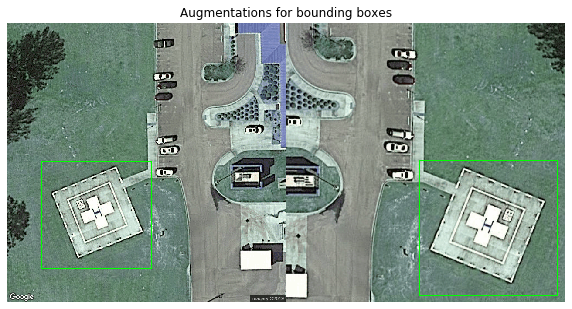

In [50]:
apply_augmentation_and_display_side_by_side(image, box, policy_v3)

In [11]:
root_image_folder = "C:\\Users\\AISG\Documents\\Jonas\\Helipad\\Helipad_DataBase"
root_meta_folder = "C:\\Users\\AISG\Documents\\Jonas\\Helipad\\Helipad_DataBase_meta"
augmentation_strategy = policy_v3
augmentation_version = 10
nb_replication = 15

image_augmentation = ImageAugmentation(root_image_folder=root_image_folder,
                                       root_meta_folder=root_meta_folder,
                                       augmentation_strategy=augmentation_strategy,
                                       augmentation_version=augmentation_version,
                                       nb_replication=nb_replication)

image_augmentation.run()

100%|██████████| 88170/88170 [21:23<00:00, 68.70it/s] 


In [176]:
subdir = 'Folder_001'
subdir_aug = '_augmented_'.join(subdir.split('_'))
print(subdir_aug)

Folder_augmented_001


In [162]:
image, bboxes, meta = load_image_box("Helipad_00076")

In [174]:
import time

start = time.time()
image_augmentation("Helipad_00076", policy_v3, 0)
end = time.time()

print(end-start)

0.020951509475708008


In [6]:
aug = iaa.Sometimes(5/6,iaa.OneOf(
                                            [
                                                iaa.Fliplr(1), 
                                                iaa.Flipud(1), 
                                                iaa.Affine(rotate=(-45, 45)), 
                                                iaa.Affine(rotate=(-90, 90)), 
                                                iaa.Affine(scale=(0.5, 1.5)),
                                                iaa.GaussianBlur(sigma=(0.0, 3.0))
                                             ]
                                        )
                                   )

In [74]:
box_aug.bounding_boxes[0]

BoundingBox(x1=79.3983, y1=318.0927, x2=403.8031, y2=550.7893, label=None)

In [130]:
for box in box_aug.bounding_boxes:
        print(box)

BoundingBox(x1=79.3983, y1=318.0927, x2=403.8031, y2=550.7893, label=None)


In [9]:
images = np.array(
    [image for _ in range(32)],
    dtype=np.uint8
)

https://github.com/matterport/Mask_RCNN/issues/1015
https://www.kaggle.com/c/data-science-bowl-2018/discussion/53495
https://github.com/matterport/Mask_RCNN/issues/768
https://medium.com/@a.karazhay/guide-augment-images-and-multiple-bounding-boxes-for-deep-learning-in-4-steps-with-the-notebook-9b263e414dac
https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html

https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9